## 南瓜定价

加载所需的库和数据集。将数据转换为一个包含数据子集的数据框：

- 仅获取按蒲式耳定价的南瓜
- 将日期转换为月份
- 计算价格为高价和低价的平均值
- 将价格转换为反映按蒲式耳数量定价


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [54]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


一个基本的散点图提醒我们，我们只有从八月到十二月的月度数据。我们可能需要更多数据才能以线性方式得出结论。


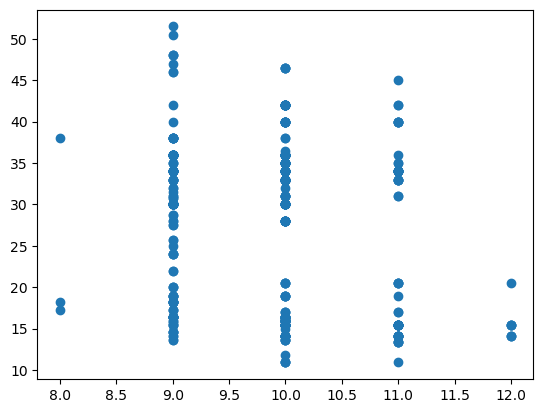

In [55]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

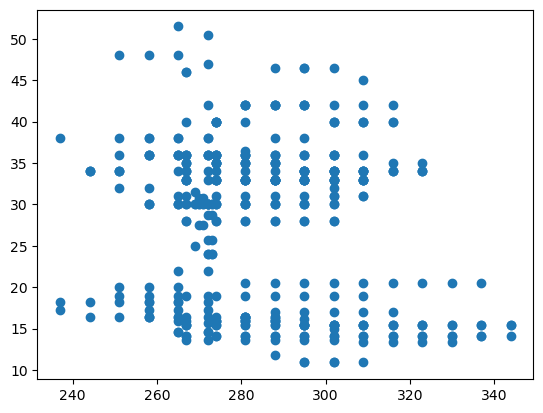

In [56]:

plt.scatter('DayOfYear','Price',data=new_pumpkins)

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pie_pumpinks = new_pumpkins[new_pumpkins['Variety'] == 'PIE TYPE']
pie_pumpinks.sort_values(by=['DayOfYear'])
x = pie_pumpinks['DayOfYear'].to_numpy().reshape(-1, 1)
y = pie_pumpinks['Price']

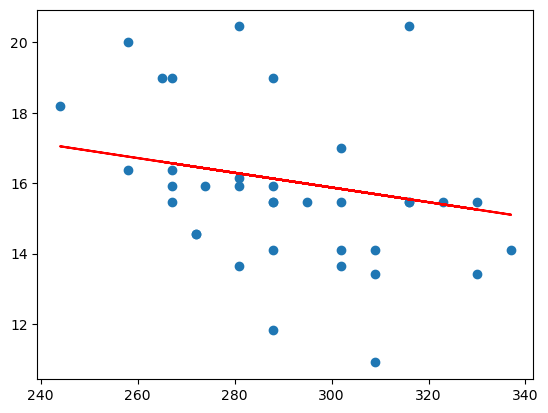

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
line_model = LinearRegression()
line_model.fit(x_train, y_train)
pred = line_model.predict(x_test)
plt.plot(x_test, pred, color='red')
plt.scatter(x_test, y_test)

In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(x_train, y_train)
pred = pipeline.predict(x_test)
# 对x_test y_test pred进行同步排序
sort = np.argsort(x_test.flatten())
pred = pred[sort]
y_test = y_test.to_numpy()[ sort]
x_test = x_test[sort]

In [60]:
x = pd.get_dummies(new_pumpkins['Variety'])['PIE TYPE'].to_numpy().reshape(-1, 1)
y = new_pumpkins['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
line_model.fit(x_train, y_train)
pred = line_model.predict(x_test)

In [65]:
x = pd.get_dummies(new_pumpkins['Variety']).join(new_pumpkins['Month']).join(pd.get_dummies(new_pumpkins['City'])).join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(x_train, y_train)
pred = pipeline.predict(x_test)
mse = np.sqrt(mean_squared_error(y_test, pred))
print(pipeline.score(x_test, y_test))

0.9605813083580833
